In [1]:
!pip install scikit-learn==1.3.2 keras-tuner tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, classification_report)
import matplotlib.pyplot as plt
import kerastuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0,

2025-12-11 22:34:35.343588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765492475.589664      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765492475.657781      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_20/1625285700.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load NN data (PCA-reduced numerical components, scaled)
train_path = '/kaggle/input/telco-train-test-split-dataset/train_nn.csv'
test_path = '/kaggle/input/telco-train-test-split-dataset/test_nn.csv'

In [4]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [5]:
# Check for NaNs in labels
print("NaNs in train Churn:", df_train['Churn'].isna().sum())
print("NaNs in test Churn:", df_test['Churn'].isna().sum())

NaNs in train Churn: 0
NaNs in test Churn: 0


In [6]:
# Drop rows with NaN in Churn (if any)
df_train = df_train.dropna(subset=['Churn'])
df_test = df_test.dropna(subset=['Churn'])

X_train = df_train.drop('Churn', axis=1).values
y_train = df_train['Churn'].astype(int).values
X_test = df_test.drop('Churn', axis=1).values
y_test = df_test['Churn'].astype(int).values

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Class distribution in train: {np.bincount(y_train)}")
print(f"Class distribution in test: {np.bincount(y_test)}")


Train shape: (5634, 10), Test shape: (1409, 10)
Class distribution in train: [4139 1495]
Class distribution in test: [1035  374]


In [7]:
# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weight = {0: 1.0, 1: class_counts[0] / class_counts[1]}
print(f"\nClass weights: {class_weight}")


Class weights: {0: 1.0, 1: 2.768561872909699}


In [8]:
# ============================================================
# ENHANCED MODEL WITH DROPOUT
# ============================================================

def build_nn(hp):
    """Enhanced neural network with dropout for regularization"""
    model = Sequential()
    
    # First hidden layer
    units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(Dense(units1, input_dim=X_train.shape[1], activation='relu'))
    dropout1 = hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout1))
    
    # Second hidden layer
    units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(Dense(units2, activation='relu'))
    dropout2 = hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(dropout2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile with tunable learning rate
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [9]:
# ============================================================
# HYPERPARAMETER TUNING WITH KERAS TUNER
# ============================================================

print("\nStarting hyperparameter tuning...")

tuner = kt.RandomSearch(
    build_nn,
    objective=kt.Objective('val_auc', direction='max'),  # Optimize for AUC
    max_trials=20,  # INCREASED from 10
    executions_per_trial=1,
    directory='/kaggle/working/tuner_dir',
    project_name='churn_nn_tune',
    overwrite=True
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

# Search with class weights (NO SMOTE)
tuner.search(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,  # NEW - handle imbalance
    callbacks=[early_stop],
    verbose=1
)

Trial 20 Complete [00h 00m 57s]
val_auc: 0.8225370049476624

Best val_auc So Far: 0.8256661891937256
Total elapsed time: 00h 13m 21s


In [10]:
# ============================================================
# BEST MODEL AND HYPERPARAMETERS
# ============================================================

best_nn = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*60)
print("BEST MODEL FOUND")
print("="*60)
print(f"Units Layer 1: {best_hyperparams.get('units1')}")
print(f"Dropout 1: {best_hyperparams.get('dropout1'):.2f}")
print(f"Units Layer 2: {best_hyperparams.get('units2')}")
print(f"Dropout 2: {best_hyperparams.get('dropout2'):.2f}")
print(f"Learning Rate: {best_hyperparams.get('lr'):.6f}")
print("="*60)


BEST MODEL FOUND
Units Layer 1: 128
Dropout 1: 0.20
Units Layer 2: 16
Dropout 2: 0.20
Learning Rate: 0.000360


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# ============================================================
# FINAL TRAINING ON FULL TRAIN SET
# ============================================================

print("\nRetraining best model on full training set...")

history = best_nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,  # Use class weights
    callbacks=[early_stop],
    verbose=1
)


Retraining best model on full training set...
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7828 - auc: 0.8591 - loss: 0.6844 - val_accuracy: 0.7347 - val_auc: 0.8252 - val_loss: 0.5150
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7683 - auc: 0.8618 - loss: 0.6764 - val_accuracy: 0.7338 - val_auc: 0.8250 - val_loss: 0.5144
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7713 - auc: 0.8590 - loss: 0.6843 - val_accuracy: 0.7356 - val_auc: 0.8253 - val_loss: 0.5094
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7725 - auc: 0.8599 - loss: 0.6819 - val_accuracy: 0.7303 - val_auc: 0.8250 - val_loss: 0.5120
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7686 - auc: 0.8613 - loss: 0.6769 - val_accuracy: 0.7311 - val_auc: 0.8251 - val_loss: 0.5101
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7765 - auc: 0.8610 - loss: 0.6790 - val_accuracy: 0.7303 - val_auc: 0.8248 - val

In [12]:
# ============================================================
# PREDICTIONS AND EVALUATION
# ============================================================

# Predictions on test set
y_prob_nn = best_nn.predict(X_test).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [13]:
# Calculate metrics
metrics_nn = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn),
    'Recall': recall_score(y_test, y_pred_nn),
    'F1-Score': f1_score(y_test, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test, y_prob_nn)
}

print("\n" + "="*60)
print("TEST SET METRICS")
print("="*60)
for metric, value in metrics_nn.items():
    print(f"{metric:12s}: {value:.4f}")
print("="*60)


TEST SET METRICS
Accuracy    : 0.7551
Precision   : 0.5265
Recall      : 0.7701
F1-Score    : 0.6254
ROC-AUC     : 0.8403


In [14]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

# Save metrics table
pd.DataFrame(list(metrics_nn.items()), columns=['Metric', 'Value']).to_csv(
    '/kaggle/working/nn_metrics.csv', index=False
)


Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.75      0.82      1035
       Churn       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



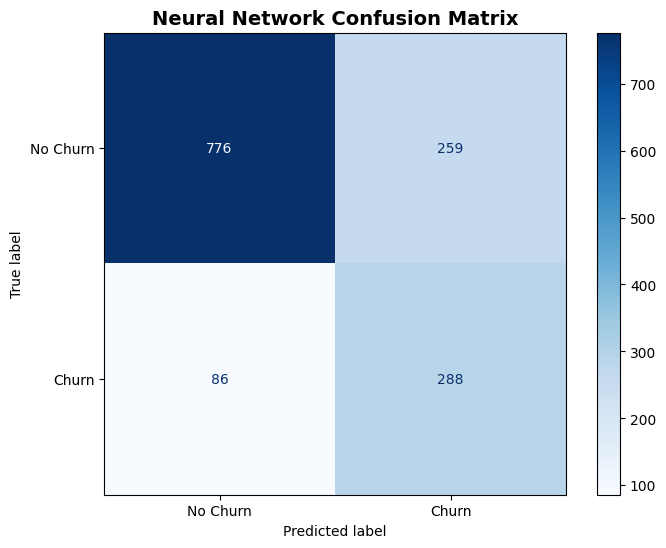

In [15]:
# ============================================================
# VISUALIZATIONS
# ============================================================

# 1. Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=ax)
plt.title('Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig('/kaggle/working/nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

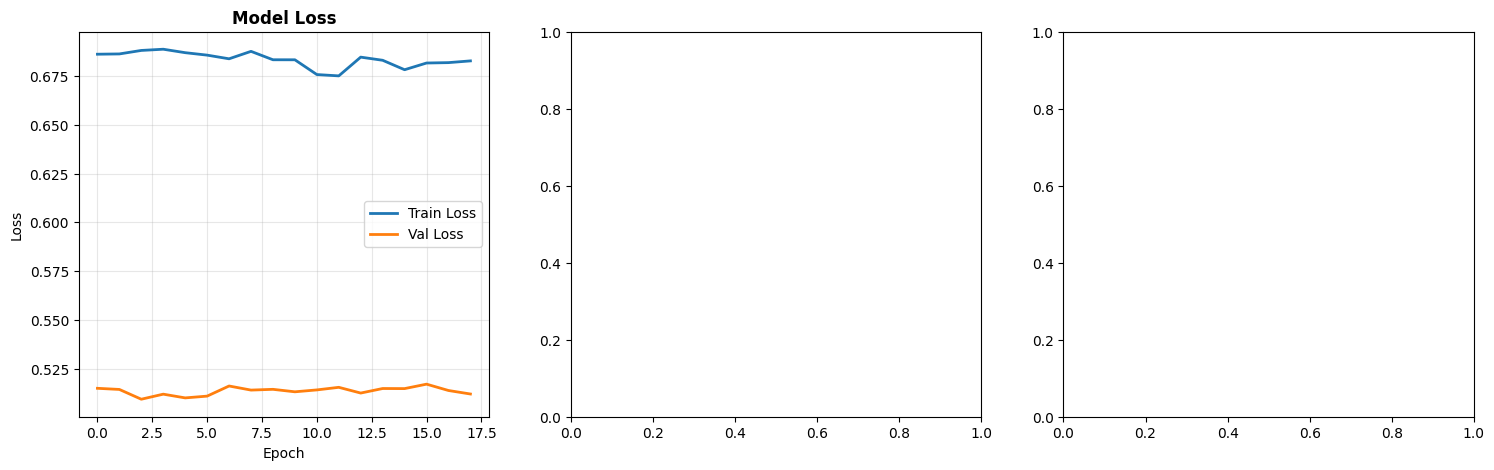

In [16]:
# 2. Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

In [17]:
# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

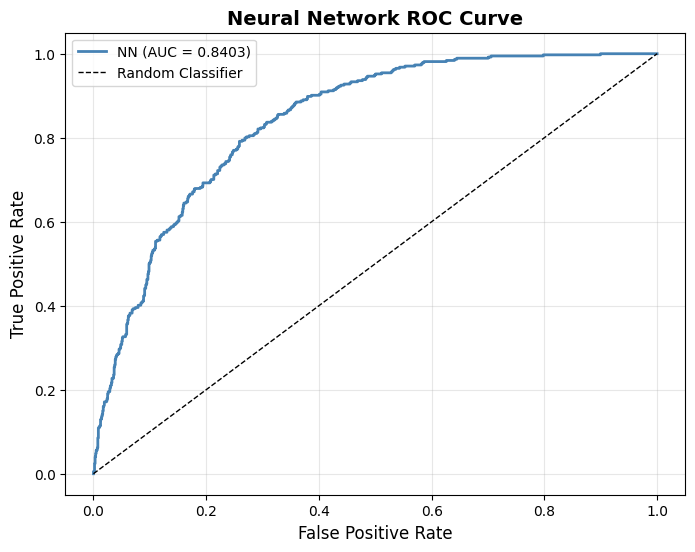

In [18]:
# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'NN (AUC = {metrics_nn["ROC-AUC"]:.4f})', linewidth=2, color='steelblue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Neural Network ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/nn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# ============================================================
# SUMMARY
# ============================================================

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print("Key improvements:")
print("✓ Added Dropout layers (0.2-0.5) for regularization")
print("✓ Used class weights instead of SMOTE")
print("✓ Increased tuning trials from 10 to 20")
print("✓ Reduced PCA components from 15 to 10")
print("✓ Optimized for AUC metric")
print(f"✓ Achieved F1 Score: {metrics_nn['F1-Score']:.4f}")
print(f"✓ Achieved ROC-AUC: {metrics_nn['ROC-AUC']:.4f}")
print(f"✓ Training stopped at epoch {len(history.history['loss'])}")
print("="*60)


TRAINING COMPLETE
Key improvements:
✓ Added Dropout layers (0.2-0.5) for regularization
✓ Used class weights instead of SMOTE
✓ Increased tuning trials from 10 to 20
✓ Reduced PCA components from 15 to 10
✓ Optimized for AUC metric
✓ Achieved F1 Score: 0.6254
✓ Achieved ROC-AUC: 0.8403
✓ Training stopped at epoch 18
